# Task 4: Finance meets Data Science

In this task, I'll work with finance data from the Postgres database. The tasks are the following:

1. Plot the prices of **bitcoin**, **ethereum** and **cardano** for the last 30 days, commit those plots images in your repo. *Hint: You can use pandas’ read_sql_query, or read_sql_table to query data from Postgres.*
2. Loading all data from the daily stock value table as a Dataframe, generate the following new features:

    **a.** Define 3 types of coins: “High Risk” if it had a 50% price drop on any two consecutive days, during a given calendar month, “Medium risk” if it dropped more than 20%, and “Low risk” for the rest (in this same fashion of consecutive days).

    **b.** For each row-day, add a column indicating the general trend of the price for the previous 7 days (T0 vs. T-1 through T-8), and the variance of the price for the same 7 days period.
   
3. To perform predictions on this time series we’ll need to have a slightly diferent structure in the dataframe. Instead of having only the price and date for each row (plus the newly generated features), we’ll also want the price of the last 7 days as columns as well as the next day’s price, which will be used as a target variable.

    **a.** You can now add extra features if you’d like, for example with feature scaling or with the skewness of the stock.

    **b.** Add any other time features you’d like such as what day of the week is this? Is this a weekend or weekday? What week of the year is this? What month? Etc.

    **c.** Play with the data regarding the volume transacted to create new features.

    **d.** Bonus: Add extra features for both China’s and US’ holidays using Python’s holiday package.

4. Regression: For every (coin, date) row in your dataset with date T0, predict the next day's price (T1) based on the previous 7 days of the stock's price and the previous features. You can use a simple linear regression model for this task, however you canpresent any model you think is best for the problem, even better if there is shown evidence of improvement over a linear regression.
*Note, the seven rows with the earliest date will not have any previous dates on
which to predict! So you need to skip these predictions.*

## Check packages and hardware, import libraries 

In [1]:
# Check python version, it should be 3.8.X:
!python --version

Python 3.12.7


In [2]:
# Check GPU hardware (code can run on CPU as well, although ML training will take longer)
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU (UUID: GPU-e0a5587a-26b1-8b4f-7e49-068b2b957994)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

## Get data

In [4]:
# Database connection details
db_params = {
    "host": "127.0.0.1",
    "port": 5432,
    "dbname": "postgres",
    "user": "postgres",
    "password": "ferMLEexam"  # replace with your Postgres password
}

In [5]:
SQL_last_30days = """
WITH coins_month AS (
	SELECT
		coin AS coin_id,
        date,
		price AS price_usd
	FROM coin_data
)
SELECT
	coin_id,
	date,
	price_usd
FROM coins_month
"""

In [6]:
# Connect and run query
with psycopg2.connect(**db_params) as conn:
    df = pd.read_sql(SQL_last_30days, conn)

# Convert date from string to datetime:
df['date'] = pd.to_datetime(df['date'])

# Show the DataFrame
df.head()

/tmp/ipykernel_39900/585361422.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(SQL_last_30days, conn)


,coin_id,date,price_usd
0,bitcoin,2021-01-01,29022.418395
1,bitcoin,2021-01-02,29352.126792
2,bitcoin,2021-01-03,32163.824935
3,bitcoin,2021-01-04,33008.226203
4,bitcoin,2021-01-05,31515.575967


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   coin_id    819 non-null    object        
 1   date       819 non-null    datetime64[ns]
 2   price_usd  819 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 19.3+ KB


In [8]:
for col in df.select_dtypes(include='object'): 
    unique_categories = df[col].unique()
    print(f'There are {len(unique_categories)} unique values in the {col} feature.')

There are 3 unique values in the coin_id feature.


In [9]:
df.describe()

,date,price_usd
count,819,819.000000
mean,2021-05-17 00:00:00,15627.978131
min,2021-01-01 00:00:00,0.175679
25%,2021-03-10 00:00:00,1.658604
50%,2021-05-17 00:00:00,2217.301853
75%,2021-07-24 00:00:00,35857.792923
max,2021-09-30 00:00:00,63576.676041
std,NaN,21158.202909


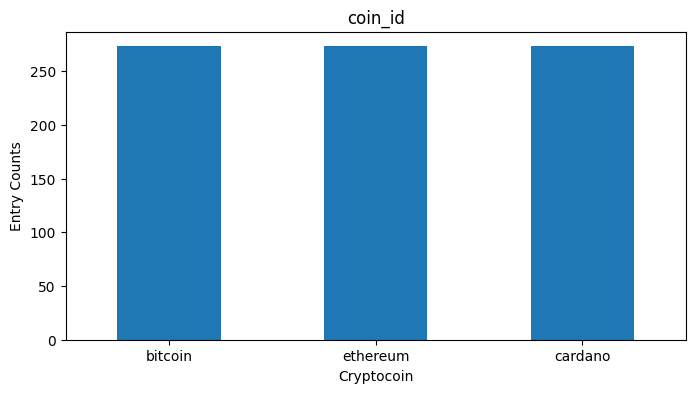

In [10]:
category_counts = df['coin_id'].value_counts()
plt.figure(figsize=(8, 4))
category_counts.plot(kind='bar')
plt.title('Frequency of cryptocoins')
plt.xlabel('Cryptocoin')
plt.ylabel('Entry Counts')
plt.xticks(rotation=0) # Keep x-axis labels horizontal for better readability
plt.title(col)
plt.show()

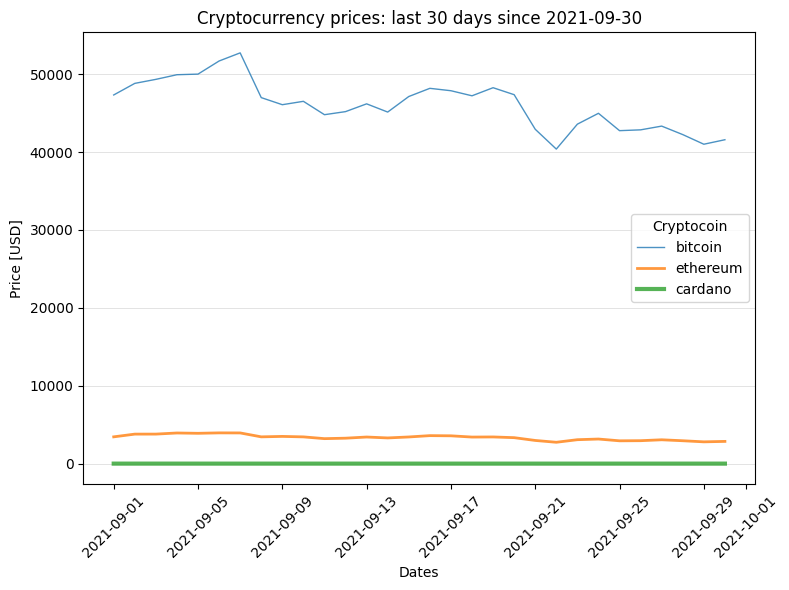

In [11]:
# Plot prices of each coin for last N days:
last_N_days = 30
COINS = ['bitcoin','ethereum','cardano']

# Filter last N days
max_date = df['date'].max()
cutoff_date = max_date - pd.Timedelta(days=last_N_days)
df_last_N = df[df['date'] > cutoff_date].sort_values('date')

save_path = 'Images/'
fig = plt.figure(figsize=(8, 6))
for i,coin in enumerate(COINS):
    df_coin = df_last_N[df_last_N['coin_id']==coin]
    plt.plot(df_coin['date'],df_coin['price_usd'],alpha=0.8,label=coin,lw=1+i)
plt.title(f'Cryptocurrency prices: last {last_N_days} days since {max_date.date()}')
plt.xlabel('Dates')
plt.ylabel('Price [USD]')
plt.xticks(rotation=45)
plt.grid(True, axis='y', lw=0.5, alpha=0.5)
plt.legend(title='Cryptocoin')
fig.tight_layout()
plt.savefig(save_path+f'Crypto_prices_for_last_{last_N_days}_days_since_{max_date.date()}.png')

In [12]:
# Activity 2: risk categories

In [13]:
# Evaluate risks for each coin for a target month, defined as:
# - High: if the coin experienced a 50% or higher price drop on any two consecutive days.
# - Medium: if the coin is not High risk, AND if it experienced between 20% and 50% price drop on any two consecutive days.
# - Low: if the coin is not High risk nor Medium risk.
import calendar

def get_month_df(df, month):
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # If month is a string, convert to number
    if isinstance(month, str):
        month = month.strip().lower()
        try:
            month_num = list(calendar.month_name).index(month.capitalize())
        except ValueError:
            month_num = list(calendar.month_abbr).index(month.capitalize())
    else:
        month_num = int(month)
    
    # Filter DataFrame
    df_month = df[df['date'].dt.month == month_num].copy()
    return df_month

In [16]:
def evaluate_risks(df_month, coins=COINS, drop_streak_days=1):
    dfm = df_month[df_month['coin_id'].isin(coins)].copy()
    dfm = dfm.sort_values(['coin_id', 'date'])

    # Extract the month (assumes all rows in df_month are same month)
    month = dfm['date'].dt.month.iloc[0]
    year = dfm['date'].dt.year.iloc[0]
    
    coin_risk = []
    for coin, df_coin in dfm.groupby('coin_id', sort=False):
        # Assigns percentage change between consecutive days to the dataframe filtered by coin:
        df_coin = df_coin.assign(pct_change=df_coin['price_usd'].pct_change()*100)

        # Check if there was a 50% or more drop for consecutive days:
        drop_50 = (df_coin['pct_change'] <= -50).astype(int)
        # Check if there was between 20% and 50% drop for consecutive days:
        drop_20_50 = ((df_coin['pct_change'] <= -20) & (df_coin['pct_change'] > -50)).astype(int)

        consec_50 = drop_50.rolling(drop_streak_days, min_periods=drop_streak_days).sum().ge(drop_streak_days).any()
        consec_20_50 = drop_20_50.rolling(drop_streak_days, min_periods=drop_streak_days).sum().ge(drop_streak_days).any()
        # two_consec_50 = (drop_50.rolling(2).sum() == 2).any()
        # two_consec_20_50 = (drop_20_50.rolling(2).sum() == 2).any()

        if consec_50:
            risk = 'High'
        elif consec_20_50:
            risk = 'Medium'
        else:
            risk = 'Low'

        coin_risk.append({
            'coin_id': coin, 
            'risk_level': risk,
            'month':month,
            'year':year
        })

    return pd.DataFrame(coin_risk)

# Usage
month = 5
df_risks = evaluate_risks(get_month_df(df, month), COINS, drop_streak_days=1)
df_risks

,coin_id,risk_level,month,year
0,bitcoin,Low,5,2021
1,cardano,Medium,5,2021
2,ethereum,Medium,5,2021


In [21]:
# Copy original dataframe:
df_risks = df.copy()

# Add year and month for grouping
df_risks['year'] = df_risks['date'].dt.year
df_risks['month'] = df_risks['date'].dt.month

# Evaluate risks for each month
risk_rows = []
for (y, m), df_month in df.groupby(['year', 'month']):
    risk_rows.append(evaluate_risks(df_month, coins=COINS, drop_streak_days=1))

# Concatenate all monthly results
df_risk_summary = pd.concat(risk_rows, ignore_index=True)
df_risk_summary

# Combine summary with daily dataset:
df_risks = df.merge(df_risk_summary, on=['coin_id', 'year', 'month'], how='left')
df_risks.head()

,coin_id,date,price_usd,year,month,risk_level
0,bitcoin,2021-01-01,29022.418395,2021,1,Low
1,bitcoin,2021-01-02,29352.126792,2021,1,Low
2,bitcoin,2021-01-03,32163.824935,2021,1,Low
3,bitcoin,2021-01-04,33008.226203,2021,1,Low
4,bitcoin,2021-01-05,31515.575967,2021,1,Low


In [22]:
def add_trend_and_variance(
    df,
    trend_method="slope", 
    window_back_days=7,
    fraction_criterion=0.05
):
    df_trend = df.copy()
    # Make sure dates are sorted in ascending order:
    df_trend = df.sort_values(["coin_id", "date"])

    # Window length, including the current day:
    win = int(window_back_days) + 1

    # Calculate variance for each coin:
    df_trend["variance"] = (
        df_trend.groupby("coin_id")["price_usd"]
          .transform(lambda s: s.rolling(win, min_periods=win).var())
    )

    # Analyze the general trend, according to the input criterion:
    if trend_method == "compare_extremes":
        # Compare the price at current day p0 vs price 7 days before (p-7) using a relative threshold:
        base = df_trend.groupby("coin_id")["price_usd"].shift(window_back_days) # p-7
        rel_diff = (df_trend["price_usd"] - base) / base  # Relative difference over the window
        # Assign trend category:
        df_trend["trend"] = np.select(
            [rel >  fraction_criterion,
             rel < -fraction_criterion],
            ["Rising", "Dropping"],
            default="Flat" # This gives the Flat category to NaN values
        )

    elif trend_method == "slope":
        # Analyze the slope of the present and last 7 days using linear regression,
        # ... and assign trend category using the tolerance fraction:
        def slope_lin(a):
            x = np.arange(len(a), dtype=float) # Array of as many integers as days in the window
            y = a.astype(float) # Price values
            # Slope in price units per day:
            return np.polyfit(x, y, 1)[0]
        # Calculate the slope for rolling windows:
        slope_series = (
            df_trend.groupby("coin_id")["price_usd"]
              .transform(lambda s: s.rolling(win, min_periods=win).apply(slope_lin, raw=True))
        )
        # Determine relative change compared to current price:
        rel_change = slope_series*win / df_trend["price_usd"]
        # Assign trend category:
        df_trend["trend"] = np.select(
            [slope_series*win >  fraction_criterion,
             slope_series*win < -fraction_criterion],
            ["Rising", "Dropping"],
            default="Flat"
        )
    else:
        raise ValueError("trend_method must be 'slope' or 'compare_extremes'")

    return df_trend

In [26]:
# Add general trend and variance:
window_back_days = 7 # N back days for the time interval analysis. The current day is extra, then there are N+1 days in the interval
trend_method = 'slope' # Criterion for the general trend
fraction_criterion = 0.05 # Fraction criterion used in the general trend method
df_trend = add_trend_and_variance(
    df_risks,
    window_back_days=window_back_days,
    trend_method=trend_method,
    fraction_criterion=fraction_criterion
)

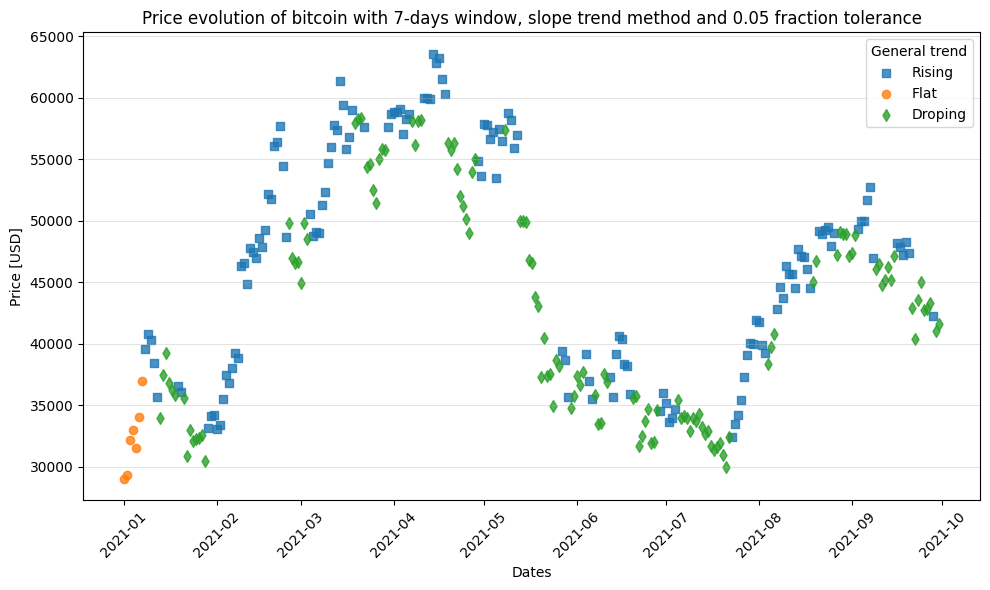

In [33]:
# Let's check the trend method:
coin = 'bitcoin'
df_coin = df_trend[df_trend['coin_id']==coin]
df_coin_rising = df_coin[df_coin['trend']=='Rising']
df_coin_flat = df_coin[df_coin['trend']=='Flat']
df_coin_droping = df_coin[df_coin['trend']=='Dropping']

save_path = 'Images/'
fig = plt.figure(figsize=(10, 6))
plt.scatter(df_coin_rising['date'],df_coin_rising['price_usd'],alpha=0.8,label='Rising',marker='s')
plt.scatter(df_coin_flat['date'],df_coin_flat['price_usd'],alpha=0.8,label='Flat',marker='o')
plt.scatter(df_coin_droping['date'],df_coin_droping['price_usd'],alpha=0.8,label='Droping',marker='d')
plt.title(f'Price evolution of {coin} with {window_back_days}-days window, {trend_method} trend method and {fraction_criterion} fraction tolerance')
plt.xlabel('Dates')
plt.ylabel('Price [USD]')
plt.xticks(rotation=45)
plt.grid(True, axis='y', lw=0.5, alpha=0.5)
plt.legend(title='General trend')
fig.tight_layout()
plt.savefig(save_path+f'Trend_{window_back_days}days_window_{trend_method}_method_{fraction_criterion}_fraction.png')

In [39]:
def add_lagged_features(
    df, 
    target_col='price_usd',
    win=7
):
    # Add lagged features:
    df_lagged = df.copy()
    for i in range(1, win + 1):
        df_lagged[f"{target_col}-{i}"] = df_lagged[target_col].shift(i)
        
    # Reorder columns: everything except target, then target, then lags
    lag_cols = [f"{target_col}-{i}" for i in range(1, win + 1)]
    other_cols = [c for c in df.columns if c != target_col]
    df_lagged = df_lagged[other_cols + [target_col] + lag_cols]
    
    return df_lagged

In [40]:
# Add lagged features:
df_lagged = add_lagged_features(df_trend,win=window_back_days)
df_lagged.head(10)

,coin_id,date,year,month,risk_level,variance,trend,price_usd,price_usd-1,price_usd-2,price_usd-3,price_usd-4,price_usd-5,price_usd-6,price_usd-7
0,bitcoin,2021-01-01,2021,1,Low,NaN,Flat,29022.418395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bitcoin,2021-01-02,2021,1,Low,NaN,Flat,29352.126792,29022.418395,NaN,NaN,NaN,NaN,NaN,NaN
2,bitcoin,2021-01-03,2021,1,Low,NaN,Flat,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,NaN,NaN
3,bitcoin,2021-01-04,2021,1,Low,NaN,Flat,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,NaN
4,bitcoin,2021-01-05,2021,1,Low,NaN,Flat,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN
5,bitcoin,2021-01-06,2021,1,Low,NaN,Flat,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN
6,bitcoin,2021-01-07,2021,1,Low,NaN,Flat,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN
7,bitcoin,2021-01-08,2021,1,Low,1.302984e+07,Rising,39547.084081,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395
8,bitcoin,2021-01-09,2021,1,Low,1.632857e+07,Rising,40815.961855,39547.084081,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792
9,bitcoin,2021-01-10,2021,1,Low,1.464934e+07,Rising,40296.529004,40815.961855,39547.084081,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935


In [54]:
import holidays

def add_calendar_features(df):
    # Make dataset copy:
    df_calendar = df.copy()

    # Add weekend flag (Saturday=5, Sunday=6):
    df_calendar['is_weekend'] = df_calendar['date'].dt.weekday.isin([5, 6]).astype(int)

    # Prepare holiday calendars:
    us_holidays = holidays.UnitedStates(years=df_calendar['date'].dt.year.unique())
    cn_holidays = holidays.China(years=df_calendar['date'].dt.year.unique())

    # Add holiday flags:
    df_calendar['is_US_holiday'] = df_calendar['date'].dt.date.isin(us_holidays).astype(int)
    df_calendar['is_China_holiday'] = df_calendar['date'].dt.date.isin(cn_holidays).astype(int)

    return df_calendar

In [62]:
# Add date-related features:
df_calendar = add_calendar_features(df_lagged)
df_calendar

,coin_id,date,year,month,risk_level,variance,trend,price_usd,price_usd-1,price_usd-2,price_usd-3,price_usd-4,price_usd-5,price_usd-6,price_usd-7,is_weekend,is_US_holiday,is_China_holiday
0,bitcoin,2021-01-01,2021,1,Low,NaN,Flat,29022.418395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1,bitcoin,2021-01-02,2021,1,Low,NaN,Flat,29352.126792,29022.418395,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2,bitcoin,2021-01-03,2021,1,Low,NaN,Flat,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,NaN,NaN,1,0,0
3,bitcoin,2021-01-04,2021,1,Low,NaN,Flat,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,NaN,0,0,0
4,bitcoin,2021-01-05,2021,1,Low,NaN,Flat,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,ethereum,2021-09-26,2021,9,Low,50815.256750,Dropping,2946.970846,2930.742706,3159.269866,3074.119761,2744.111000,2977.322679,3335.884887,3427.584262,1,0,0
542,ethereum,2021-09-27,2021,9,Low,30653.933314,Dropping,3063.316345,2946.970846,2930.742706,3159.269866,3074.119761,2744.111000,2977.322679,3335.884887,0,0,0
543,ethereum,2021-09-28,2021,9,Low,15532.011554,Rising,2939.742283,3063.316345,2946.970846,2930.742706,3159.269866,3074.119761,2744.111000,2977.322679,0,0,0
544,ethereum,2021-09-29,2021,9,Low,19615.944814,Dropping,2798.984417,2939.742283,3063.316345,2946.970846,2930.742706,3159.269866,3074.119761,2744.111000,0,0,0


In [64]:
# Map risk levels to numbers (if not done yet):
risk_map = {'Low': 1, 'Medium': 2, 'High': 3}
if df_calendar['risk_level'].dtype == object:
    df_calendar['risk_level'] = df_calendar['risk_level'].map(risk_map)
df_calendar.head(10)

,coin_id,date,year,month,risk_level,variance,trend,price_usd,price_usd-1,price_usd-2,price_usd-3,price_usd-4,price_usd-5,price_usd-6,price_usd-7,is_weekend,is_US_holiday,is_China_holiday
0,bitcoin,2021-01-01,2021,1,1,NaN,Flat,29022.418395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1
1,bitcoin,2021-01-02,2021,1,1,NaN,Flat,29352.126792,29022.418395,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2,bitcoin,2021-01-03,2021,1,1,NaN,Flat,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,NaN,NaN,1,0,0
3,bitcoin,2021-01-04,2021,1,1,NaN,Flat,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,NaN,0,0,0
4,bitcoin,2021-01-05,2021,1,1,NaN,Flat,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,NaN,0,0,0
5,bitcoin,2021-01-06,2021,1,1,NaN,Flat,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN,NaN,0,0,0
6,bitcoin,2021-01-07,2021,1,1,NaN,Flat,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,NaN,0,0,0
7,bitcoin,2021-01-08,2021,1,1,1.302984e+07,Rising,39547.084081,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,29022.418395,0,0,0
8,bitcoin,2021-01-09,2021,1,1,1.632857e+07,Rising,40815.961855,39547.084081,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,29352.126792,1,0,0
9,bitcoin,2021-01-10,2021,1,1,1.464934e+07,Rising,40296.529004,40815.961855,39547.084081,36933.520137,34082.206049,31515.575967,33008.226203,32163.824935,1,0,0


In [ ]:
# Possible new feature:
# coin price / marketcap volume

In [65]:
df_calendar.columns

Index(['coin_id', 'date', 'year', 'month', 'risk_level', 'variance', 'trend',
       'price_usd', 'price_usd-1', 'price_usd-2', 'price_usd-3', 'price_usd-4',
       'price_usd-5', 'price_usd-6', 'price_usd-7', 'is_weekend',
       'is_US_holiday', 'is_China_holiday'],
      dtype='object')

In [70]:
# Normalization of prices
def normalize_prices(df,lag_window,col_price_root='price_usd'):
    df_norm_prices = df.copy()
    # Keep the original yesterday price:
    df_norm_prices[f'{col_price_root}-1_orig'] = df[f'{col_price_root}-1']
    # Normalize the price features:
    for lag in range(1, lag_window+1):
        df_norm_prices[f'{col_price_root}-{lag}'] = df[f'{col_price_root}-{lag}'] / df[f'{col_price_root}-1']
    return df_norm_prices

In [85]:
# Remove the first 7 rows and normalize price features:
df_full = normalize_prices(df_calendar,window_back_days)
# Drop NaN rows, which are the first {window_back_days} days for each coin:
df_full = df_full.dropna()
df_full.head(5)

,coin_id,date,year,month,risk_level,variance,trend,price_usd,price_usd-1,price_usd-2,price_usd-3,price_usd-4,price_usd-5,price_usd-6,price_usd-7,is_weekend,is_US_holiday,is_China_holiday,price_usd-1_orig
7,bitcoin,2021-01-08,2021,1,1,1.302984e+07,Rising,39547.084081,1.0,0.922799,0.853306,0.893720,0.870857,0.794729,0.785802,0,0,0,36933.520137
8,bitcoin,2021-01-09,2021,1,1,1.632857e+07,Rising,40815.961855,1.0,0.933913,0.861813,0.796913,0.834656,0.813305,0.742207,1,0,0,39547.084081
9,bitcoin,2021-01-10,2021,1,1,1.464934e+07,Rising,40296.529004,1.0,0.968912,0.904879,0.835022,0.772139,0.808709,0.788021,1,0,0,40815.961855
10,bitcoin,2021-01-11,2021,1,1,1.259364e+07,Rising,38397.895985,1.0,1.012890,0.981402,0.916543,0.845785,0.782092,0.819133,0,0,0,40296.529004
11,bitcoin,2021-01-12,2021,1,1,1.057691e+07,Rising,35669.906687,1.0,1.049446,1.062974,1.029928,0.961863,0.887606,0.820763,0,0,0,38397.895985


## Time to train!

Start with LinearRegression, 1 model per coin

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_per_coin_models_LinearRegression(
    df, 
    target='price_usd', 
    ref_price='price_usd-1_orig',
    coin_col='coin_id',
    date_col='date',
    drop_cols = ['coin_id', 'date', 'risk_level', 'trend'],
    train_frac=0.75
):
    """
    Train one Linear Regression model per coin to predict T0 price (normalized) 
    based on past 7 days & other available features.
    
    Parameters
    ----------
    df : pd.DataFrame
        Full dataset containing features and target.
    target : str
        Name of the target column (normalized price_usd at T0).
    ref_price : str
        Column name holding original price_usd-1 for rescaling.
        
    Returns
    -------
    models : dict
        {coin_id: trained_model}
    results : pd.DataFrame
        RMSE results per coin (absolute prices).
    """
    models = {}
    results = []

    # Features to drop (not used for training)
    if drop_cols is None:
        drop_cols = [ref_price, target]
    else:
        drop_cols.extend([ref_price, target])
    
    for coin, df_coin in df.groupby(coin_col):
        df_coin = df_coin.sort_values(date_col).reset_index(drop=True)
        
        # Split chronological:
        split_idx = int(len(df_coin) * train_frac)
        train_df = df_coin.iloc[:split_idx]
        test_df = df_coin.iloc[split_idx:]
        
        # Define X and y
        feature_cols = [c for c in df_coin.columns if c not in drop_cols]
        X_train = train_df[feature_cols]
        y_train = train_df[target]
        X_test  = test_df[feature_cols]
        y_test  = test_df[target]
        
        # Fit model
        model = LinearRegression()
        model.fit(X_train, y_train)
        models[coin] = model
        
        # Predict (normalized)
        y_pred_norm = model.predict(X_test)
        
        # Scale back to absolute prices
        y_pred_abs = y_pred_norm * test_df[ref_price].values
        y_test_abs = y_test * test_df[ref_price].values
        
        # Compute RMSE on absolute prices
        rmse = mean_squared_error(y_test_abs, y_pred_abs, squared=False)
             
        results.append({'coin_id': coin, 'RMSE_abs_price': rmse})
    
    results_df = pd.DataFrame(results)
    return models, results_df

In [139]:
models_LinReg, results_df_LinReg = train_per_coin_models_LinearRegression(df_full)

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [147]:
def plot_predictions(
    df, 
    models, 
    target='price_usd', 
    ref_price='price_usd-1_orig',
    coin_col='coin_id',
    date_col='date',
    drop_cols = ['coin_id', 'date', 'risk_level', 'trend'],
    coin_to_plot=None,
    train_frac=0.75,
    save_path=None
):
    """
    Plot predictions vs ground truth for the test set of each coin (or a specific one).
    """
    
    # Features to drop:
    if drop_cols is None:
        drop_cols = [ref_price, target]
    else:
        drop_cols.extend([ref_price, target])
    
    coins = [coin_to_plot] if coin_to_plot else list(models.keys())
    
    for coin in coins:
        df_coin = df[df[coin_col] == coin].sort_values(date_col).reset_index(drop=True)
        split_idx = int(len(df_coin) * train_frac)
        test_df = df_coin.iloc[split_idx:]
        
        feature_cols = [c for c in df_coin.columns if c not in drop_cols]
        X_test = test_df[feature_cols]
        y_test = test_df[target]
        
        # Predict (normalized) and rescale
        y_pred_norm = models[coin].predict(X_test)
        y_pred_abs = y_pred_norm * test_df[ref_price].values
        y_test_abs = y_test * test_df[ref_price].values
        # Compute RMSE on absolute prices
        rmse = mean_squared_error(y_test_abs, y_pred_abs, squared=False)

        model_name = str(models[coin]).split('(')[0] 

        # Plot
        fig = plt.figure(figsize=(10, 5))
        plt.plot(test_df['date'], y_test_abs, label='Ground Truth', lw=1, ls='--', alpha=0.8)
        plt.plot(test_df['date'], y_pred_abs, label='Prediction', lw=2, ls='-', alpha=0.8)
        plt.title(f'{coin} — Ground Truth vs Prediction — Model {model_name} — RMSE {rmse}')
        plt.xlabel('Date')
        plt.ylabel('Price [USD]')
        plt.legend()
        plt.grid(True, axis='y', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        fig.tight_layout()
        if save_path is not None:
            plt.savefig(save_path+f'Model_preds_{coin}_model_{model_name}')
        plt.show()

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


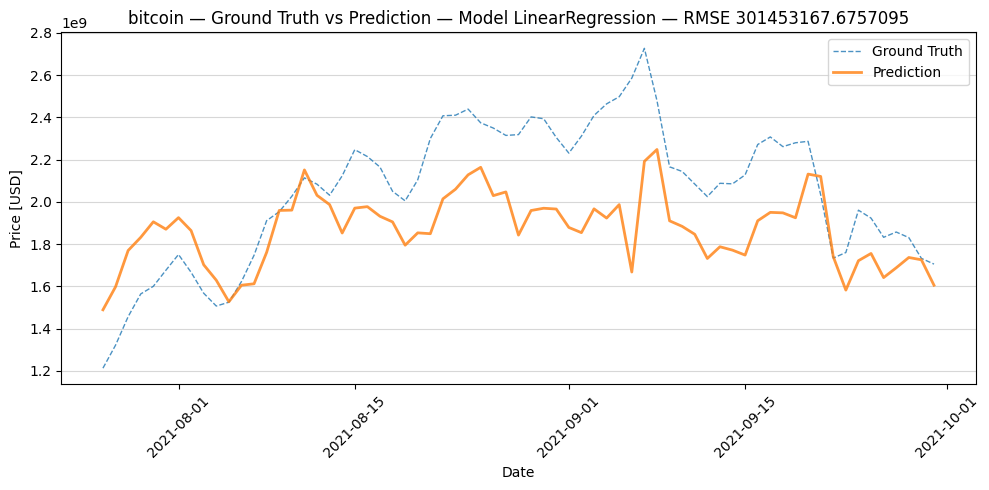

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


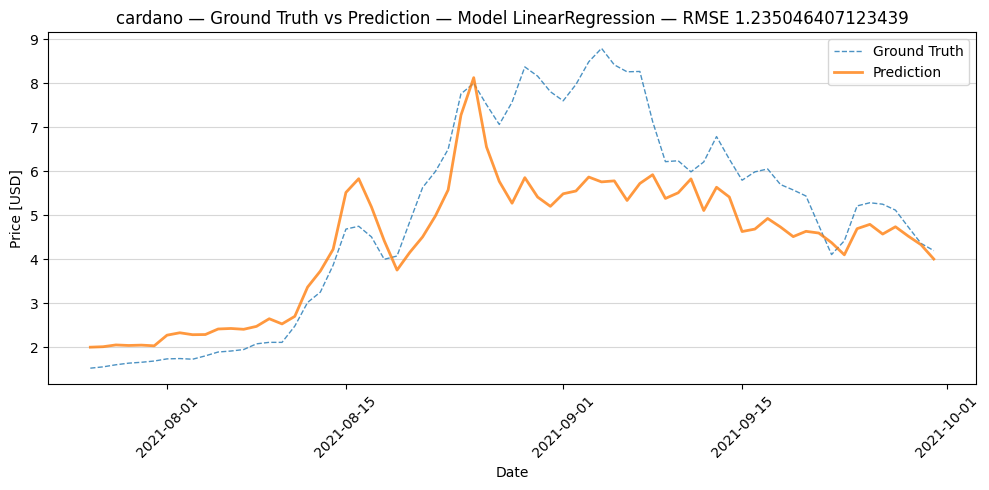

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


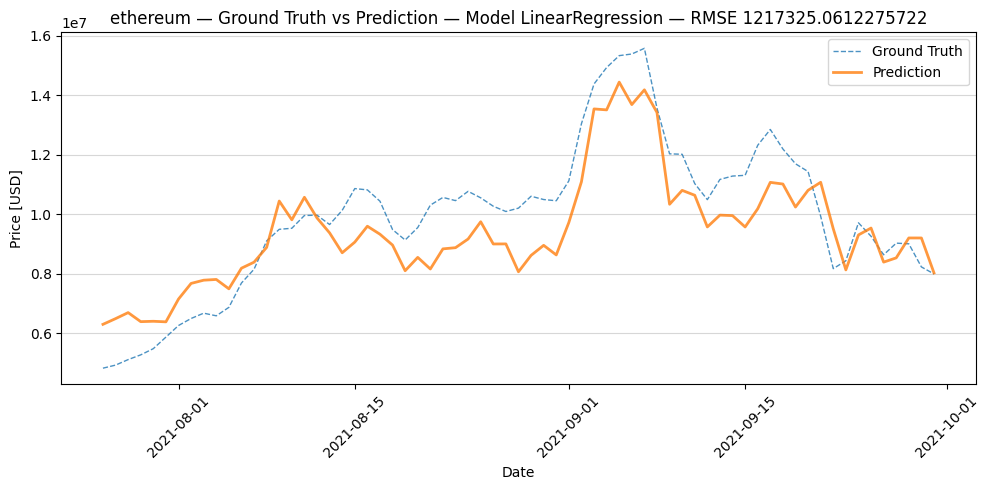

In [148]:
# Plot predictions on test set:
save_path = 'Images/'
plot_predictions(df_full, models_LinReg,save_path=save_path)

In [142]:
# RandomForestRegressor now:

In [143]:
from sklearn.ensemble import RandomForestRegressor

def train_per_coin_rf_models(
    df,
    target='price_usd',
    ref_price='price_usd-1_orig',
    coin_col='coin_id',
    date_col='date',
    drop_cols = ['coin_id', 'date', 'risk_level', 'trend'],
    train_frac=0.75,
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=1,
    random_state=17,
    n_jobs=-1
):
    """
    Train one RandomForestRegressor per coin to predict normalized T0 price.
    Returns trained models and RMSE (on absolute price) per coin.
    """
    models = {}
    results = []

    # Drop cols:
    if drop_cols is None:
        drop_cols = [ref_price, target]
    else:
        drop_cols.extend([ref_price, target])

    for coin, df_coin in df.groupby('coin_id'):
        df_coin = df_coin.sort_values('date').reset_index(drop=True)

        # Chronological split
        split_idx = int(len(df_coin) * train_frac)
        train_df = df_coin.iloc[:split_idx]
        test_df  = df_coin.iloc[split_idx:]

        feature_cols = [c for c in df_coin.columns if c not in drop_cols]
        X_train = train_df[feature_cols]
        y_train = train_df[target]
        X_test  = test_df[feature_cols]
        y_test  = test_df[target]

        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=n_jobs
        )
        rf.fit(X_train, y_train)
        models[coin] = rf

        # Predict normalized, then rescale to absolute
        y_pred_norm = rf.predict(X_test)
        y_pred_abs  = y_pred_norm * test_df[ref_price].values
        y_test_abs  = y_test * test_df[ref_price].values

        rmse = mean_squared_error(y_test_abs, y_pred_abs, squared=False)
        results.append({'coin_id': coin, 'RMSE_abs_price': rmse})

    return models, pd.DataFrame(results)

In [156]:
models_RF, results_df_RF = train_per_coin_rf_models(
    df_full,
    n_estimators=100,
    max_depth=3,
)

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


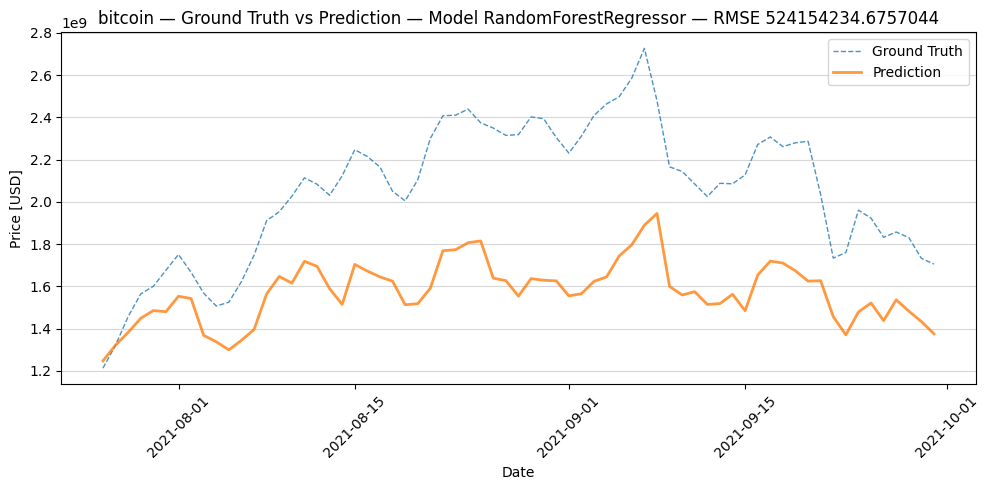

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


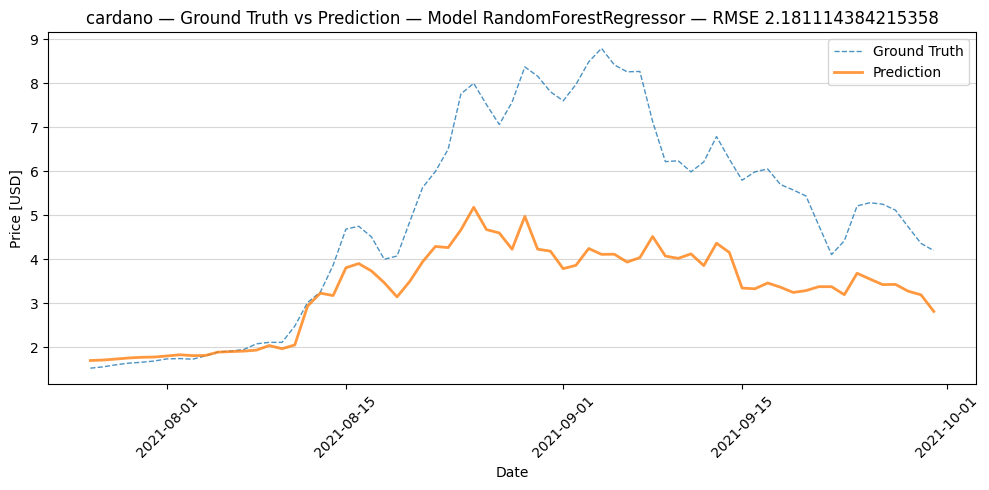

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


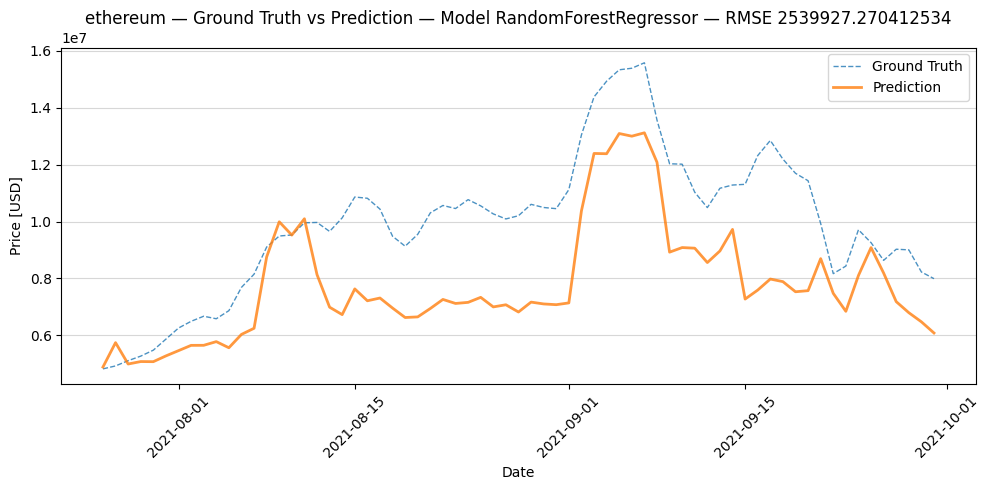

In [157]:
# Plot predictions on test set:
save_path = 'Images/'
plot_predictions(df_full, models_RF,save_path=save_path)

In [ ]:
# XGBRegressor

In [170]:
from xgboost import XGBRegressor

def train_per_coin_xgb_models(
    df,
    target='price_usd',
    ref_price='price_usd-1_orig',
    coin_col='coin_id',
    date_col='date',
    drop_cols=['coin_id', 'date', 'risk_level', 'trend'],
    train_frac=0.75,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=17,
    n_jobs=-1,
    early_stopping_rounds=50
):
    """
    Train one XGBRegressor per coin to predict normalized T0 price.
    Returns trained models and RMSE (on absolute price) per coin.
    """
    models = {}
    results = []

    # Drop cols:
    if drop_cols is None:
        drop_cols = [ref_price, target]
    else:
        drop_cols.extend([ref_price, target])

    for coin, df_coin in df.groupby(coin_col):
        df_coin = df_coin.sort_values(date_col).reset_index(drop=True)

        # Chronological split
        split_idx = int(len(df_coin) * train_frac)
        train_df = df_coin.iloc[:split_idx]
        test_df  = df_coin.iloc[split_idx:]

        feature_cols = [c for c in df_coin.columns if c not in drop_cols]
        X_train = train_df[feature_cols]
        y_train = train_df[target]
        X_valid = test_df[feature_cols]     # use test as early-stop valid (or carve a val split from train)
        y_valid = test_df[target]

        # Model
        xgb = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_lambda=reg_lambda,
            random_state=random_state,
            n_jobs=n_jobs,
            tree_method="hist",
            objective="reg:squarederror",
            eval_metric="rmse",
            early_stopping_rounds=early_stopping_rounds
        )

        # Fit with early stopping
        xgb.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        models[coin] = xgb

        # Predict normalized, then rescale to absolute
        y_pred_norm = xgb.predict(X_valid)
        y_pred_abs  = y_pred_norm * test_df[ref_price].values
        y_test_abs  = y_valid * test_df[ref_price].values

        rmse = mean_squared_error(y_test_abs, y_pred_abs, squared=False)
        results.append({'coin_id': coin, 'RMSE_abs_price': rmse})

    return models, pd.DataFrame(results)

In [171]:
models_XGBR, results_df_XGBR = train_per_coin_xgb_models(
    df_full,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=17,
    n_jobs=-1,
    early_stopping_rounds=50
)

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


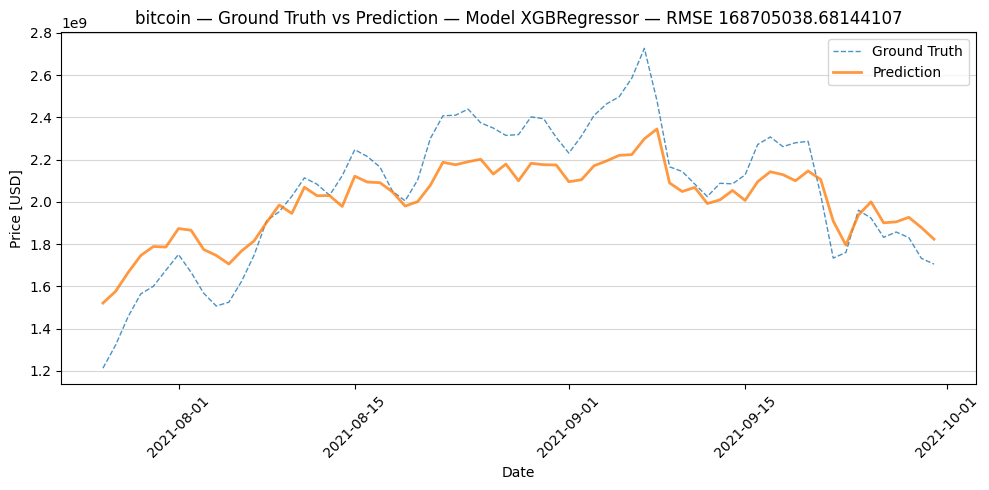

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


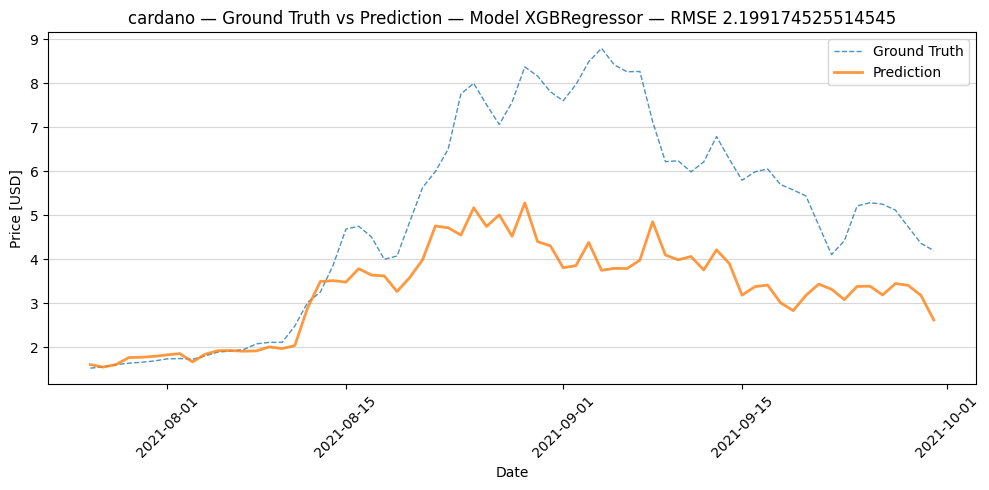

/home/meneses/miniconda3/envs/py12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


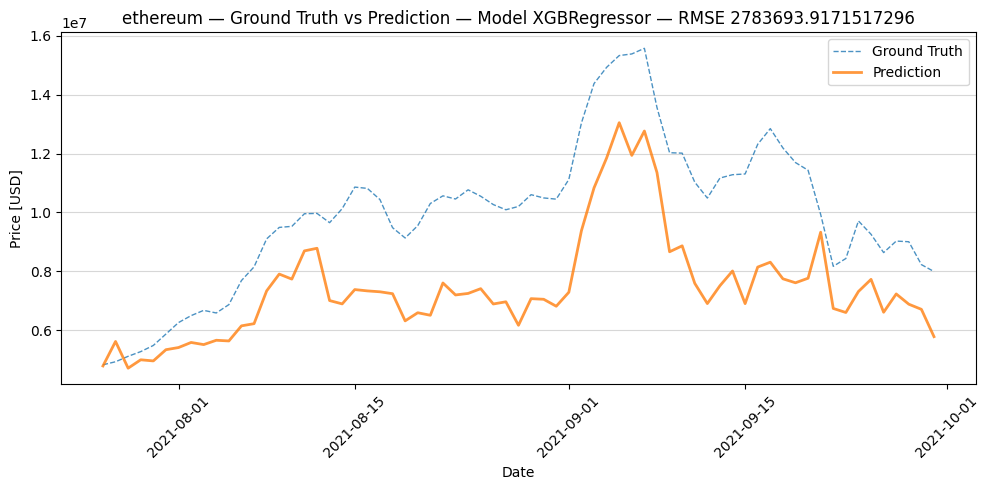

In [172]:
# Plot predictions on test set:
save_path = 'Images/'
plot_predictions(df_full, models_XGBR,save_path=save_path)